In [1]:
import torch
import torch.optim as optim
import torch.utils.data as data
from torchsummary import summary
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def index_classes(items):
    idx = {}
    for i in items:
        if (i not in idx):
            idx[i] = len(idx)
    return idx

class MiniImagenet(data.Dataset):
    """
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/vision/datasets/mini_imagenet.py)
    **Description**
    The *mini*-ImageNet dataset was originally introduced by Vinyals et al., 2016.
    It consists of 60'000 colour images of sizes 84x84 pixels.
    The dataset is divided in 3 splits of 64 training, 16 validation, and 20 testing classes each containing 600 examples.
    The classes are sampled from the ImageNet dataset, and we use the splits from Ravi & Larochelle, 2017.
    **References**
    1. Vinyals et al. 2016. “Matching Networks for One Shot Learning.” NeurIPS.
    2. Ravi and Larochelle. 2017. “Optimization as a Model for Few-Shot Learning.” ICLR.
    **Arguments**
    * **root** (str) - Path to download the data.
    * **mode** (str, *optional*, default='train') - Which split to use.
        Must be 'train', 'validation', or 'test'.
    * **transform** (Transform, *optional*, default=None) - Input pre-processing.
    * **target_transform** (Transform, *optional*, default=None) - Target pre-processing.
    * **download** (bool, *optional*, default=False) - Download the dataset if it's not available.
    **Example**
    ~~~python
    ~~~
    """
    def __init__(
        self,
        root,
        mode='train',
        transform=None,
        target_transform=None):
        super(MiniImagenet, self).__init__()
        self.root = os.path.expanduser(root)
        if not os.path.exists(self.root):
            os.mkdir(self.root)
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        pickle_file = os.path.join(self.root, 'mini-imagenet-cache-' + mode + '.pkl')

        with open(pickle_file, 'rb') as f:
            self.data = pickle.load(f)

   #     self.x = torch.from_numpy(self.data["image_data"]).permute(0, 3, 1, 2).float()
        self.x =self.data["image_data"]
        self.y = np.ones(len(self.x))

        # TODO Remove index_classes from here
        self.class_idx = index_classes(self.data['class_dict'].keys())
        for class_name, idxs in self.data['class_dict'].items():
            for idx in idxs:
                self.y[idx] = self.class_idx[class_name]

    def __getitem__(self, idx):
        data = self.x[idx]
        if self.transform:
            data = self.transform(data)
        return data, self.y[idx]

    def __len__(self):
        return len(self.x)


In [3]:
import math
import torch.nn as nn
from kernel import CannyFilter

In [4]:
transform=T.Compose([T.ToTensor(),T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_set=MiniImagenet(root="D:/Dataset/Mini-ImageNet",mode='train',transform=transform)
torch.manual_seed(0)
train_set, val_set = torch.utils.data.random_split(train_set, [30000, 8400])


In [5]:
img=train_set[321][0]*0.5+0.5

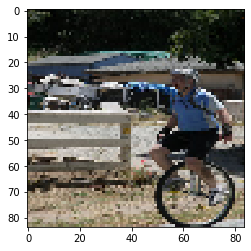

In [6]:
plt.imshow(T.ToPILImage()(img))

In [7]:
import random 

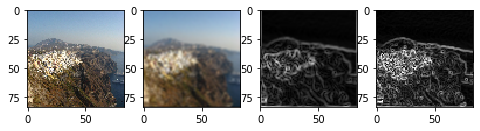

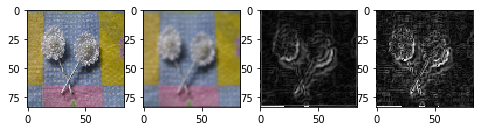

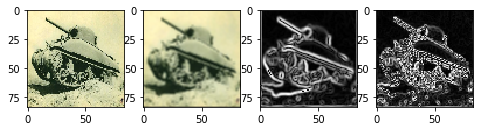

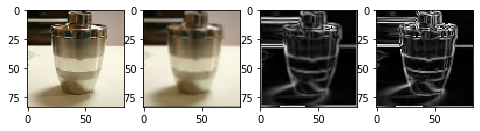

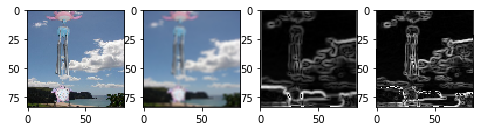

In [8]:
for _ in range(5):
    img_idx=random.randint(0,len(train_set)-1)
    canny_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=False)
    blur_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False)
    img=train_set[img_idx][0]*0.5+0.5
    outputs=canny_kernel(img.unsqueeze(0))
    fig,ax=plt.subplots(ncols=4,figsize=(8,16))
    noblur_outputs=blur_kernel(img.unsqueeze(0))

    ax[0].imshow(T.ToPILImage()(img))
    ax[1].imshow(T.ToPILImage()(outputs[0][0]))
    ax[2].imshow(T.ToPILImage()(outputs[1][0]),cmap='gray')
    ax[3].imshow(T.ToPILImage()(noblur_outputs[1][0]),cmap='gray')




In [9]:
train_dl = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=84,
                                          shuffle=True,
                                          drop_last=True)
valid_dl = torch.utils.data.DataLoader(dataset=val_set,
                                          batch_size=84,
                                          shuffle=False,
                                          drop_last=True)

In [10]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 32,3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

                
            
        self.layer4= torch.nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.layer5 = torch.nn.Sequential(
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
                    
        self.classifier = torch.nn.Sequential(
            nn.Linear(5 * 5 * 64, 128, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(128, 64, bias=True))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out=self.layer4(out)
      #  out = self.layer5(out)
     #   print(out.shape)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.classifier(out)
        return out

In [11]:
import torchvision.models as models
model = models.resnet18(num_classes=64)
torch.manual_seed(0)
config_=dict()
config_["lr"]=0.005
config_["crit"]=nn.CrossEntropyLoss()
config_["optim"]=optim.Adam(model.parameters(),lr=config_["lr"])
config_["save_dir"]="models/"
config_["epochs"]=30
config_['run_name']=f'edge_finetune_{stop_epoch}'
config_["accuracy"]=True
config_["log_interval"]=100
config_["device"]="cuda"

NameError: name 'stop_epoch' is not defined

In [12]:
def train(config,train_dl,valid_dl,model,kernel=None,stop_epoch=10):
    '''
    config.optimizer: Training optimizer eg) Adam,SGD....
    config.criterion: Loss eg) CrossEntropy, 
    config.lr: learning_rate
    train_dl,valid_dl: Dataloader
    model: target model
    save_path
    '''
    canny_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False,use_cuda=True)
    model.to(config["device"])
    wandb.init(project="Augmentation_Strategy")
    wandb.run.name = config['run_name']
    wandb.run.save()
    canny_kernel.to(config["device"])
    max_val_accuracy=0
    for epoch in tqdm(range(config["epochs"])):
            print(f'Epochs : {epoch+1}')
            model.train()
            avg_train_loss=0
            correct=0
            total=0
            for batch_idx,(img,label) in enumerate(train_dl):
                #Zero_grad_Optimizer
                config["optim"].zero_grad()
                img=img.to(config["device"])
                if epoch<stop_epoch:#
                    with torch.no_grad():
                       _,img=canny_kernel(img)
                       img=img.expand(-1,3,-1,-1)
              #  img=kernel(img)-img
                label=label.to(config["device"]).long()
                output=model(img)

                #Measure Loss
                loss=config["crit"](output,label)
                loss.backward()

                if config["accuracy"]:
                    _, predicted = torch.max(output.data, 1)
                    total+=label.size()[0]
                    correct += (predicted == label).sum().item()

                #Update Parameters
                config["optim"].step()
                avg_train_loss+=loss.item()
                if batch_idx % config["log_interval"]==0:
                    wandb.log({
                        "Train Accuracy": correct/(total),
                        "Train Loss": avg_train_loss/(batch_idx+1)})
            model.eval()
            valid_loss=0
            correct=0
            total=0

            for batch_idx,(img,label) in enumerate(valid_dl):

                img=img.to(config["device"])
                label=label.to(config["device"]).long()

                output=model(img)
                #Measure Loss
                loss=config["crit"](output,label)

                valid_loss+=loss.item()

                if config["accuracy"]:
                    _, predicted = torch.max(output.data, 1)
                    total+=label.size()[0]
                    correct += (predicted == label).sum().item()
            avg_valid_loss=valid_loss/(len(valid_dl))
            wandb.log({
                "epoch": epoch,
                "Val Accuracy": correct/total,
                "Val Loss": avg_valid_loss})
            if (correct/total)>max_val_accuracy:
                max_val_accuracy=correct/total
                print('Validation Result is better, saving the new model')
                torch.save(model.state_dict(), config["save_dir"]+config_['run_name'])

    return config,model

In [13]:
import wandb
model = models.resnet18(num_classes=64)
torch.manual_seed(0)
for stop_epoch in range(1,30):
    config_=dict()
    config_["lr"]=0.005
    config_["crit"]=nn.CrossEntropyLoss()
    config_["optim"]=optim.Adam(model.parameters(),lr=config_["lr"])
    config_["save_dir"]="models/"
    config_["epochs"]=30
    config_['run_name']=f'edge_finetune_{stop_epoch}'
    config_["accuracy"]=True
    config_["log_interval"]=100
    config_["device"]="cuda"
    config_,model=train(config_,train_dl,valid_dl,model,stop_epoch=stop_epoch)


wandb: Currently logged in as: hslrock (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
C:\Users\admin\anaconda3\lib\site-packages\torch\tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:59<28:50, 59.66s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:45<25:58, 55.66s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:32<23:49, 52.95s/it]

Validation Result is better, saving the new model
Epochs : 4


 13%|███████████                                                                        | 4/30 [03:19<22:06, 51.00s/it]

Validation Result is better, saving the new model
Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:05<20:42, 49.70s/it]

Validation Result is better, saving the new model
Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [04:52<19:29, 48.74s/it]

Validation Result is better, saving the new model
Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [05:38<18:24, 48.01s/it]

Validation Result is better, saving the new model
Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [06:24<17:25, 47.51s/it]

Validation Result is better, saving the new model
Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [07:11<16:29, 47.14s/it]

Validation Result is better, saving the new model
Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [07:57<15:39, 46.99s/it]

Validation Result is better, saving the new model
Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [08:44<14:49, 46.83s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [09:30<14:01, 46.74s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [10:17<13:12, 46.64s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [11:03<12:24, 46.51s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [11:50<11:39, 46.61s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [12:36<10:51, 46.56s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [13:22<10:04, 46.48s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [14:09<09:16, 46.41s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [14:55<08:30, 46.37s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [15:43<07:49, 46.94s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [16:31<07:03, 47.06s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [17:18<06:17, 47.13s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [18:05<05:29, 47.12s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [18:52<04:43, 47.23s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [19:40<03:56, 47.28s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [20:27<03:09, 47.25s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [21:14<02:21, 47.21s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [22:01<01:34, 47.12s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [22:49<00:47, 47.26s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [23:36<00:00, 47.21s/it]


Train Accuracy,▁▁▂▃▄▃▄▅▅▅▆▇▇▇██████████████████████████
Train Loss,█▇▇▆▅▅▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▅▅▆▇██████████████▇█▇▇████▇██
Val Loss,█▂▂▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▃▄▃▃▄▃▃▄▄▄
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.98683
Train Loss,0.04014
Val Accuracy,0.42321
Val Loss,4.50663
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:59<28:35, 59.16s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:57<27:32, 59.01s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:45<24:58, 55.49s/it]

Validation Result is better, saving the new model
Epochs : 4


 13%|███████████                                                                        | 4/30 [03:32<22:59, 53.06s/it]

Validation Result is better, saving the new model
Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:19<21:22, 51.30s/it]

Validation Result is better, saving the new model
Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:07<20:03, 50.16s/it]

Validation Result is better, saving the new model
Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [05:54<18:56, 49.40s/it]

Validation Result is better, saving the new model
Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [06:42<17:54, 48.84s/it]

Validation Result is better, saving the new model
Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [07:29<16:56, 48.38s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [08:17<16:01, 48.09s/it]

Validation Result is better, saving the new model
Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [09:04<15:10, 47.90s/it]

Validation Result is better, saving the new model
Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [09:51<14:18, 47.71s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [10:38<13:28, 47.54s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [11:25<12:37, 47.36s/it]

Validation Result is better, saving the new model
Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [12:13<11:49, 47.29s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [13:00<11:02, 47.31s/it]

Validation Result is better, saving the new model
Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [13:47<10:15, 47.36s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [14:35<09:28, 47.37s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [15:22<08:41, 47.45s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [16:10<07:54, 47.50s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [16:57<07:07, 47.48s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [17:45<06:19, 47.44s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [18:32<05:31, 47.41s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [19:19<04:44, 47.40s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [20:07<03:56, 47.34s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [20:54<03:09, 47.38s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [21:42<02:22, 47.40s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [22:29<01:34, 47.38s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [23:16<00:47, 47.25s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [24:03<00:00, 48.12s/it]


Train Accuracy,▁▃▆██████████████████████████▇██████████
Train Loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁███████████████████▇▇▇▇▇▇▇▇▇
Val Loss,▇█▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▃▃▃▃▃
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99367
Train Loss,0.02161
Val Accuracy,0.42905
Val Loss,4.61328
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:59<28:41, 59.37s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:59<27:48, 59.58s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:58<26:46, 59.49s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:46<24:12, 55.88s/it]

Validation Result is better, saving the new model
Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:33<22:14, 53.37s/it]

Validation Result is better, saving the new model
Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:20<20:37, 51.55s/it]

Validation Result is better, saving the new model
Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:08<19:17, 50.33s/it]

Validation Result is better, saving the new model
Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [06:55<18:08, 49.46s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [07:43<17:06, 48.88s/it]

Validation Result is better, saving the new model
Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [08:29<16:03, 48.15s/it]

Validation Result is better, saving the new model
Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [09:16<15:06, 47.69s/it]

Validation Result is better, saving the new model
Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [10:02<14:11, 47.29s/it]

Validation Result is better, saving the new model
Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [10:49<13:20, 47.07s/it]

Validation Result is better, saving the new model
Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [11:36<12:31, 46.94s/it]

Validation Result is better, saving the new model
Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [12:22<11:42, 46.82s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [13:08<10:53, 46.69s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [13:55<10:05, 46.56s/it]

Validation Result is better, saving the new model
Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [14:41<09:18, 46.52s/it]

Validation Result is better, saving the new model
Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [15:27<08:30, 46.42s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [16:14<07:43, 46.37s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [17:00<06:56, 46.32s/it]

Validation Result is better, saving the new model
Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [17:46<06:10, 46.31s/it]

Validation Result is better, saving the new model
Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [18:32<05:23, 46.26s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [19:19<04:37, 46.33s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [20:05<03:51, 46.32s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [20:51<03:05, 46.31s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [21:38<02:18, 46.33s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [22:24<01:32, 46.33s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [23:10<00:46, 46.37s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [23:57<00:00, 47.91s/it]


Train Accuracy,▁▄▇█▄██████████████████████████████████▇
Train Loss,█▃▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▇█████████████████████████▇
Val Loss,▄▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.92818
Train Loss,0.26394
Val Accuracy,0.40548
Val Loss,3.69727
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:58<28:05, 58.13s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:56<27:07, 58.13s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:53<26:06, 58.01s/it]

Validation Result is better, saving the new model
Epochs : 4


 13%|███████████                                                                        | 4/30 [03:54<25:31, 58.89s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:42<23:04, 55.38s/it]

Validation Result is better, saving the new model
Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:29<21:10, 52.95s/it]

Validation Result is better, saving the new model
Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:16<19:39, 51.27s/it]

Validation Result is better, saving the new model
Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:04<18:22, 50.09s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [07:51<17:14, 49.26s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [08:38<16:12, 48.60s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [09:25<15:16, 48.24s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [10:13<14:22, 47.93s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [11:00<13:31, 47.73s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [11:47<12:41, 47.59s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [12:34<11:52, 47.51s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [13:22<11:03, 47.43s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [14:09<10:15, 47.34s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [14:56<09:27, 47.33s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [15:43<08:40, 47.29s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [16:30<07:52, 47.25s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [17:18<07:05, 47.30s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [18:05<06:17, 47.22s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [18:52<05:30, 47.25s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [19:40<04:43, 47.28s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [20:27<03:56, 47.29s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [21:14<03:09, 47.29s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [22:01<02:21, 47.30s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [22:49<01:34, 47.27s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [23:36<00:47, 47.31s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [24:24<00:00, 48.80s/it]


Train Accuracy,▁▅██████████████████████████████████████
Train Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁████▇████▇▇██████████████▇
Val Loss,▆▇██▁▁▁▁▁▁▁▁▁▂▂▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99312
Train Loss,0.02251
Val Accuracy,0.40155
Val Loss,5.88737
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [01:00<29:02, 60.07s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:59<27:56, 59.88s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:59<26:56, 59.88s/it]

Validation Result is better, saving the new model
Epochs : 4


 13%|███████████                                                                        | 4/30 [03:58<25:54, 59.79s/it]

Validation Result is better, saving the new model
Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:58<24:55, 59.83s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:46<22:26, 56.11s/it]

Validation Result is better, saving the new model
Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:33<20:29, 53.46s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:20<18:55, 51.60s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:08<17:37, 50.35s/it]

Validation Result is better, saving the new model
Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [08:55<16:27, 49.39s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [09:42<15:26, 48.77s/it]

Validation Result is better, saving the new model
Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [10:30<14:30, 48.34s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [11:17<13:36, 48.04s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [12:04<12:43, 47.73s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [12:51<11:53, 47.57s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [13:38<11:04, 47.49s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [14:26<10:17, 47.53s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [15:13<09:29, 47.47s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [16:01<08:42, 47.46s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [16:48<07:54, 47.42s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [17:35<07:05, 47.33s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [18:23<06:18, 47.31s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [19:10<05:31, 47.30s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [19:57<04:44, 47.33s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [20:44<03:56, 47.27s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [21:31<03:08, 47.20s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [22:19<02:21, 47.24s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [23:06<01:34, 47.28s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [23:53<00:47, 47.26s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [24:40<00:00, 49.37s/it]


Train Accuracy,▁▅██████████████████████████████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁███████▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇▇
Val Loss,▆▇▇██▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▂▂▁▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99577
Train Loss,0.01169
Val Accuracy,0.41976
Val Loss,6.05635
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:59<28:36, 59.18s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:58<27:34, 59.08s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:57<26:36, 59.11s/it]

Validation Result is better, saving the new model
Epochs : 4


 13%|███████████                                                                        | 4/30 [03:55<25:33, 58.98s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:54<24:33, 58.93s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:53<23:35, 58.97s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:41<21:15, 55.47s/it]

Validation Result is better, saving the new model
Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:28<19:25, 52.98s/it]

Validation Result is better, saving the new model
Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:15<17:56, 51.27s/it]

Validation Result is better, saving the new model
Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:02<16:40, 50.04s/it]

Validation Result is better, saving the new model
Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [09:49<15:34, 49.19s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [10:37<14:34, 48.60s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [11:24<13:38, 48.16s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [12:11<12:45, 47.85s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [12:58<11:54, 47.63s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [13:45<11:04, 47.46s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [14:32<10:15, 47.32s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [15:19<09:28, 47.34s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [16:07<08:41, 47.43s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [16:54<07:53, 47.33s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [17:41<07:04, 47.20s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [18:28<06:17, 47.14s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [19:15<05:29, 47.06s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [20:02<04:42, 47.02s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [20:49<03:55, 47.05s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [21:36<03:08, 47.10s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [22:23<02:21, 47.05s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [23:10<01:34, 47.04s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [23:57<00:46, 46.99s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [24:44<00:00, 49.48s/it]


Train Accuracy,▁▅██████▆███████████████████████████████
Train Loss,█▂▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁██████▇▇███▇▇█▇██▇▇▇▇█▇▇
Val Loss,▅▇▇▇██▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99806
Train Loss,0.00627
Val Accuracy,0.41333
Val Loss,5.95594
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:58<28:26, 58.86s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:57<27:23, 58.69s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:55<26:21, 58.58s/it]

Validation Result is better, saving the new model
Epochs : 4


 13%|███████████                                                                        | 4/30 [03:53<25:20, 58.46s/it]

Validation Result is better, saving the new model
Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:51<24:15, 58.21s/it]

Validation Result is better, saving the new model
Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:49<23:16, 58.20s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:47<22:19, 58.22s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:34<20:06, 54.83s/it]

Validation Result is better, saving the new model
Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:21<18:21, 52.46s/it]

Validation Result is better, saving the new model
Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:08<16:56, 50.81s/it]

Validation Result is better, saving the new model
Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [09:55<15:44, 49.69s/it]

Validation Result is better, saving the new model
Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [10:42<14:40, 48.91s/it]

Validation Result is better, saving the new model
Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [11:29<13:41, 48.34s/it]

Validation Result is better, saving the new model
Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [12:16<12:46, 47.90s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [13:03<11:54, 47.64s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [13:50<11:03, 47.41s/it]

Validation Result is better, saving the new model
Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [14:37<10:14, 47.28s/it]

Validation Result is better, saving the new model
Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [15:24<09:25, 47.15s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [16:11<08:37, 47.06s/it]

Validation Result is better, saving the new model
Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [16:58<07:50, 47.00s/it]

Validation Result is better, saving the new model
Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [17:44<07:02, 46.97s/it]

Validation Result is better, saving the new model
Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [18:31<06:15, 46.97s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [19:18<05:28, 46.98s/it]

Validation Result is better, saving the new model
Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [20:05<04:41, 47.00s/it]

Validation Result is better, saving the new model
Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [20:52<03:54, 46.97s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [21:39<03:07, 46.96s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [22:26<02:20, 46.96s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [23:13<01:33, 46.98s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [24:00<00:47, 47.00s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [24:47<00:00, 49.60s/it]


Train Accuracy,▁▅█████████████████████████████████▇████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▇██████████████████▇▇██
Val Loss,▆▇▆▇███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99917
Train Loss,0.00295
Val Accuracy,0.42607
Val Loss,5.73606
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:58<28:20, 58.65s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:56<27:17, 58.47s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:54<26:17, 58.41s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:52<25:15, 58.29s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:51<24:17, 58.30s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:49<23:18, 58.29s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:50<22:35, 58.95s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:48<21:34, 58.83s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:35<19:22, 55.33s/it]

Validation Result is better, saving the new model
Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:23<17:38, 52.93s/it]

Validation Result is better, saving the new model
Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:11<16:18, 51.51s/it]

Validation Result is better, saving the new model
Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [10:59<15:07, 50.39s/it]

Validation Result is better, saving the new model
Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [11:46<14:00, 49.43s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [12:33<13:01, 48.81s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [13:20<12:04, 48.32s/it]

Validation Result is better, saving the new model
Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [14:07<11:11, 47.97s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [14:55<10:20, 47.76s/it]

Validation Result is better, saving the new model
Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [15:42<09:30, 47.58s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [16:29<08:42, 47.52s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [17:16<07:53, 47.37s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [18:03<07:05, 47.31s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [18:51<06:17, 47.23s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [19:37<05:30, 47.14s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [20:25<04:42, 47.16s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [21:12<03:56, 47.23s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [21:59<03:09, 47.29s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [22:47<02:21, 47.24s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [23:34<01:34, 47.20s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [24:21<00:47, 47.17s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:09<00:00, 50.32s/it]


Train Accuracy,▁▆██████████████████████▇███████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁█████████▇▇████▇▇▇████
Val Loss,▆▇▇██▇▇▆▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99735
Train Loss,0.00845
Val Accuracy,0.41512
Val Loss,6.8501
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:59<28:41, 59.38s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:59<27:49, 59.62s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:58<26:47, 59.54s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:57<25:44, 59.39s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:57<24:43, 59.33s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:57<23:50, 59.59s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:56<22:48, 59.48s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:55<21:46, 59.39s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:54<20:46, 59.34s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:42<18:34, 55.71s/it]

Validation Result is better, saving the new model
Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:29<16:50, 53.21s/it]

Validation Result is better, saving the new model
Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:16<15:24, 51.37s/it]

Validation Result is better, saving the new model
Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:03<14:11, 50.09s/it]

Validation Result is better, saving the new model
Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [12:50<13:07, 49.22s/it]

Validation Result is better, saving the new model
Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [13:38<12:09, 48.61s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [14:25<11:13, 48.12s/it]

Validation Result is better, saving the new model
Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [15:12<10:21, 47.77s/it]

Validation Result is better, saving the new model
Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [15:59<09:30, 47.56s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [16:46<08:42, 47.48s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [17:33<07:53, 47.33s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [18:20<07:05, 47.23s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [19:07<06:17, 47.18s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [19:54<05:29, 47.11s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [20:41<04:42, 47.06s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [21:28<03:55, 47.04s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [22:15<03:08, 47.09s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [23:02<02:21, 47.13s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [23:49<01:34, 47.10s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [24:37<00:47, 47.12s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:24<00:00, 50.80s/it]


Train Accuracy,▁▆██████████▅███████████████████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁████████▇▇████▇▇█████
Val Loss,▆▇▇▇▇██▆▆▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99735
Train Loss,0.00787
Val Accuracy,0.41393
Val Loss,7.05845
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:59<28:46, 59.55s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:58<27:41, 59.34s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:57<26:41, 59.31s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:56<25:40, 59.26s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:55<24:38, 59.12s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:54<23:40, 59.18s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:54<22:44, 59.33s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:53<21:41, 59.16s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:52<20:40, 59.06s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:51<19:40, 59.02s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:38<17:34, 55.49s/it]

Validation Result is better, saving the new model
Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:25<15:53, 52.97s/it]

Validation Result is better, saving the new model
Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:12<14:29, 51.17s/it]

Validation Result is better, saving the new model
Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [12:59<13:18, 49.93s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [13:46<12:16, 49.09s/it]

Validation Result is better, saving the new model
Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [14:33<11:18, 48.49s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [15:20<10:24, 48.07s/it]

Validation Result is better, saving the new model
Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [16:07<09:33, 47.82s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [16:55<08:44, 47.64s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [17:42<07:54, 47.50s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [18:29<07:06, 47.38s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [19:16<06:18, 47.30s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [20:03<05:30, 47.26s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [20:51<04:43, 47.27s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [21:38<03:56, 47.23s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [22:25<03:08, 47.14s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [23:12<02:21, 47.08s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [23:59<01:34, 47.07s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [24:46<00:47, 47.08s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:33<00:00, 51.10s/it]


Train Accuracy,▁▆████████▇█████████████████████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁███████████▇████▇█▇█
Val Loss,▇▇▇██▇█▇▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99521
Train Loss,0.0171
Val Accuracy,0.41548
Val Loss,7.10935
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:59<28:42, 59.39s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:58<27:41, 59.33s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:57<26:35, 59.11s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:55<25:34, 59.01s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:54<24:34, 59.00s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:53<23:34, 58.95s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:52<22:36, 58.97s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:51<21:36, 58.94s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:50<20:37, 58.93s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:49<19:38, 58.92s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:49<18:48, 59.37s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:37<16:44, 55.79s/it]

Validation Result is better, saving the new model
Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:24<15:04, 53.21s/it]

Validation Result is better, saving the new model
Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:11<13:42, 51.38s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [13:58<12:31, 50.12s/it]

Validation Result is better, saving the new model
Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [14:46<11:30, 49.30s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [15:33<10:31, 48.59s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [16:19<09:36, 48.08s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [17:06<08:44, 47.72s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [17:53<07:55, 47.50s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [18:40<07:06, 47.37s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [19:27<06:18, 47.26s/it]

Validation Result is better, saving the new model
Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [20:15<05:30, 47.23s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [21:02<04:43, 47.24s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [21:49<03:56, 47.22s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [22:36<03:08, 47.17s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [23:23<02:21, 47.08s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [24:10<01:34, 47.06s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [24:57<00:47, 47.07s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:45<00:00, 51.50s/it]


Train Accuracy,▁▆████████▇█████████████████████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁██████▇██████▇██▇██
Val Loss,▆▇▇▇██▅▆▆▇▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99688
Train Loss,0.01018
Val Accuracy,0.41512
Val Loss,7.58997
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<28:00, 57.96s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<27:02, 57.96s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:53<26:05, 57.97s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:51<25:06, 57.95s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:49<24:05, 57.83s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:48<23:15, 58.16s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:45<22:12, 57.92s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:43<21:15, 57.95s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:41<20:14, 57.83s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:39<19:19, 57.97s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:37<18:22, 58.01s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:35<17:22, 57.93s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:21<15:23, 54.32s/it]

Validation Result is better, saving the new model
Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:07<13:49, 51.81s/it]

Validation Result is better, saving the new model
Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [13:53<12:30, 50.01s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [14:40<11:29, 49.28s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [15:26<10:27, 48.27s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [16:12<09:30, 47.57s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [16:58<08:37, 47.03s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [17:44<07:47, 46.75s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [18:30<06:58, 46.48s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [19:15<06:10, 46.25s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [20:01<05:23, 46.15s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [20:47<04:36, 46.03s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [21:33<03:49, 45.95s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [22:19<03:03, 45.93s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [23:05<02:17, 45.91s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [23:50<01:31, 45.82s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [24:36<00:45, 45.82s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:22<00:00, 50.75s/it]

Validation Result is better, saving the new model


Train Accuracy,▁▇██████████████▃███████████████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▂▁▁▂▁▁▁▁▁▁▁▁█████▇████████████
Val Loss,███▇▇█▆█▆▆██▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁▂▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99735
Train Loss,0.00884
Val Accuracy,0.4144
Val Loss,8.2467
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<27:54, 57.75s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<26:57, 57.76s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:53<25:59, 57.77s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:51<25:05, 57.92s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:49<24:07, 57.90s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:47<23:10, 57.92s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:45<22:10, 57.87s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:43<21:14, 57.93s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:40<20:12, 57.76s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:38<19:14, 57.73s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:36<18:19, 57.86s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:33<17:18, 57.68s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:31<16:21, 57.71s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:17<14:27, 54.21s/it]

Validation Result is better, saving the new model
Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:03<12:55, 51.70s/it]

Validation Result is better, saving the new model
Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [14:49<11:38, 49.90s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [15:34<10:33, 48.71s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [16:20<09:34, 47.85s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [17:06<08:40, 47.30s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [17:52<07:48, 46.84s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [18:38<06:59, 46.65s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [19:25<06:12, 46.52s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [20:10<05:24, 46.30s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [20:56<04:36, 46.12s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [21:42<03:50, 46.06s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [22:28<03:04, 46.05s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [23:14<02:18, 46.19s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [24:00<01:32, 46.13s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [24:46<00:46, 46.07s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:32<00:00, 51.09s/it]


Train Accuracy,▁▇██████████████████████████████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁█████████████████
Val Loss,▇█▇▇▇█▇█▇▆▆▆▅▁▁▁▁▁▁▂▁▁▂▁▁▁▂▂▂▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.9979
Train Loss,0.00764
Val Accuracy,0.40964
Val Loss,8.69381
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<27:59, 57.90s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<26:58, 57.80s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:53<25:59, 57.76s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:51<25:05, 57.90s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:48<24:02, 57.72s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:46<23:04, 57.68s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:43<22:05, 57.65s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:41<21:05, 57.54s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:39<20:15, 57.90s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:37<19:16, 57.81s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:35<18:17, 57.76s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:32<17:18, 57.70s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:30<16:22, 57.79s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:28<15:25, 57.85s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:14<13:35, 54.36s/it]

Validation Result is better, saving the new model
Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:00<12:06, 51.87s/it]

Validation Result is better, saving the new model
Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [15:46<10:51, 50.08s/it]

Validation Result is better, saving the new model
Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [16:32<09:46, 48.83s/it]

Validation Result is better, saving the new model
Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [17:18<08:47, 47.98s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [18:04<07:54, 47.43s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [18:50<07:02, 46.98s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [19:36<06:13, 46.73s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [20:23<05:25, 46.57s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [21:09<04:38, 46.38s/it]

Validation Result is better, saving the new model
Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [21:54<03:51, 46.23s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [22:40<03:04, 46.16s/it]

Validation Result is better, saving the new model
Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [23:27<02:18, 46.17s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [24:13<01:32, 46.12s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [24:59<00:46, 46.06s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:44<00:00, 51.50s/it]


Train Accuracy,▁▇██████████████████████████████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████▇██████████
Val Loss,█▇▇▇▇▇▇▇▇▇▆▇▇█▁▁▁▁▁▂▁▂▂▁▁▁▂▂▂▂
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99672
Train Loss,0.01275
Val Accuracy,0.40333
Val Loss,9.08796
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:58<28:02, 58.00s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<27:00, 57.87s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:53<26:03, 57.93s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:51<25:04, 57.85s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:49<24:06, 57.86s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:46<23:04, 57.69s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:44<22:08, 57.77s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:42<21:10, 57.77s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:39<20:11, 57.70s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:38<19:18, 57.90s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:35<18:17, 57.74s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:33<17:18, 57.71s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:31<16:26, 58.04s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:29<15:25, 57.83s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:26<14:25, 57.69s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:12<12:37, 54.12s/it]

Validation Result is better, saving the new model
Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [15:58<11:10, 51.61s/it]

Validation Result is better, saving the new model
Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [16:44<09:58, 49.88s/it]

Validation Result is better, saving the new model
Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [17:29<08:54, 48.63s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [18:15<07:58, 47.88s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [19:01<07:05, 47.32s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [19:47<06:15, 46.90s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [20:33<05:26, 46.61s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [21:19<04:38, 46.37s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [22:05<03:50, 46.17s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [22:50<03:04, 46.02s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [23:36<02:17, 45.89s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [24:22<01:31, 45.81s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [25:07<00:45, 45.79s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [25:53<00:00, 51.79s/it]


Train Accuracy,▁▇██████████████████████████████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████▇████████
Val Loss,█▆▆▇██▇▇▆▇▆▅▆▆▇▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99794
Train Loss,0.00618
Val Accuracy,0.39952
Val Loss,9.11905
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:58<28:12, 58.35s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:56<27:12, 58.30s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:53<26:05, 57.99s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:51<25:06, 57.94s/it]

Validation Result is better, saving the new model
Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:49<24:10, 58.03s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:48<23:13, 58.06s/it]

Validation Result is better, saving the new model
Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:46<22:15, 58.07s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:44<21:17, 58.09s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:41<20:15, 57.90s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:39<19:18, 57.94s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:37<18:21, 57.97s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:35<17:23, 58.00s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:34<16:27, 58.09s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:31<15:27, 57.99s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:29<14:27, 57.82s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:26<13:28, 57.72s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:12<11:45, 54.24s/it]

Validation Result is better, saving the new model
Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [16:58<10:20, 51.71s/it]

Validation Result is better, saving the new model
Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [17:44<09:09, 49.97s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [18:30<08:07, 48.73s/it]

Validation Result is better, saving the new model
Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [19:16<07:10, 47.85s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [20:02<06:17, 47.23s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [20:47<05:27, 46.79s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [21:33<04:39, 46.56s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [22:19<03:51, 46.39s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [23:05<03:04, 46.17s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [23:51<02:18, 46.07s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [24:37<01:32, 46.02s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [25:23<00:45, 45.99s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [26:09<00:00, 52.30s/it]


Train Accuracy,▁▇██████▇▇██▇████████▃███████▇██████████
Train Loss,▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████▇█
Val Loss,█▇▇▇█▆▆▆▆▆▇▇▆▆▅▆▁▁▁▁▁▁▁▁▁▁▁▁▂▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99846
Train Loss,0.00672
Val Accuracy,0.39286
Val Loss,9.51904
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<27:57, 57.85s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<26:58, 57.79s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:52<25:56, 57.65s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:50<24:55, 57.52s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:48<24:05, 57.81s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:46<23:07, 57.83s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:44<22:08, 57.76s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:41<21:08, 57.65s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:39<20:12, 57.75s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:37<19:15, 57.77s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:35<18:18, 57.84s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:32<17:19, 57.73s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:30<16:21, 57.71s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:28<15:23, 57.74s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:25<14:25, 57.73s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:24<13:30, 57.92s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:21<12:32, 57.86s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:08<10:52, 54.36s/it]

Validation Result is better, saving the new model
Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [17:54<09:30, 51.83s/it]

Validation Result is better, saving the new model
Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [18:39<08:20, 50.05s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [19:25<07:19, 48.85s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [20:12<06:24, 48.02s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [20:57<05:31, 47.35s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [21:43<04:41, 46.96s/it]

Validation Result is better, saving the new model
Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [22:30<03:53, 46.73s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [23:16<03:06, 46.51s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [24:01<02:18, 46.27s/it]

Validation Result is better, saving the new model
Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [24:47<01:32, 46.15s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [25:33<00:46, 46.16s/it]

Validation Result is better, saving the new model
Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [26:20<00:00, 52.67s/it]


Train Accuracy,▁▇██████████████████████████████████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▂▁█████████████
Val Loss,▅▅▅▆▅▅▄▅▅▃█▆▆▅▅▄▅▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99846
Train Loss,0.00612
Val Accuracy,0.39024
Val Loss,10.15737
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:59<28:33, 59.10s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:57<27:32, 59.01s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:55<26:20, 58.55s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:52<25:14, 58.23s/it]

Validation Result is better, saving the new model
Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:50<24:11, 58.08s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:48<23:09, 57.89s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:46<22:14, 58.01s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:43<21:13, 57.87s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:42<20:19, 58.07s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:40<19:19, 57.98s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:37<18:20, 57.92s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:35<17:18, 57.72s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:33<16:25, 57.95s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:31<15:27, 57.95s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:29<14:28, 57.90s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:27<13:29, 57.84s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:24<12:31, 57.83s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:22<11:33, 57.77s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:08<09:56, 54.19s/it]

Validation Result is better, saving the new model
Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [18:54<08:37, 51.77s/it]

Validation Result is better, saving the new model
Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [19:40<07:30, 50.01s/it]

Validation Result is better, saving the new model
Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [20:26<06:30, 48.79s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [21:12<05:35, 47.91s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [21:58<04:44, 47.34s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [22:44<03:54, 46.95s/it]

Validation Result is better, saving the new model
Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [23:30<03:07, 46.80s/it]

Validation Result is better, saving the new model
Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [24:16<02:19, 46.53s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [25:02<01:32, 46.33s/it]

Validation Result is better, saving the new model
Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [25:48<00:46, 46.18s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [26:34<00:00, 53.14s/it]


Train Accuracy,▁▇██▇███████▇███████████▇▇███▇███▇██████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
Val Accuracy,▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁██████████▇█
Val Loss,▇▆█▆▅▆▄▅▆▆▆▅▆▆▅▆▆▆▁▁▁▁▁▁▁▁▁▁▂▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99668
Train Loss,0.01361
Val Accuracy,0.37738
Val Loss,10.75715
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<27:52, 57.67s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:54<26:49, 57.47s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:52<25:56, 57.64s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:50<24:57, 57.59s/it]

Validation Result is better, saving the new model
Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:48<24:02, 57.71s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:45<23:02, 57.59s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:43<22:04, 57.58s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:40<21:07, 57.61s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:38<20:12, 57.73s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:36<19:14, 57.74s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:34<18:16, 57.73s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:32<17:24, 58.01s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:31<16:27, 58.08s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:29<15:28, 58.03s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:26<14:28, 57.91s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:24<13:30, 57.91s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:22<12:31, 57.82s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:19<11:33, 57.76s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:17<10:33, 57.64s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:03<09:01, 54.16s/it]

Validation Result is better, saving the new model
Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [19:49<07:45, 51.70s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [20:34<06:39, 49.93s/it]

Validation Result is better, saving the new model
Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [21:21<05:41, 48.78s/it]

Validation Result is better, saving the new model
Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [22:07<04:47, 47.95s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [22:52<03:56, 47.33s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [23:38<03:07, 46.90s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [24:24<02:19, 46.61s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [25:10<01:32, 46.38s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [25:56<00:46, 46.22s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [26:42<00:00, 53.43s/it]


Train Accuracy,▅▆███████████████████████▁▇██▇███████▇██
Train Loss,▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▂▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁███████████
Val Loss,▇▇▇▇▆█▅▅▆▇▆▅▆▆▆▆█▆▅▁▁▁▁▁▁▁▁▁▂▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99628
Train Loss,0.0125
Val Accuracy,0.38786
Val Loss,10.97656
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:58<28:02, 58.01s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<27:03, 57.98s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:53<26:03, 57.89s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:51<25:02, 57.77s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:48<24:01, 57.67s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:46<23:08, 57.85s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:44<22:06, 57.66s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:41<21:07, 57.61s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:39<20:09, 57.60s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:36<19:12, 57.61s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:34<18:15, 57.67s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:31<17:16, 57.56s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:29<16:20, 57.67s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:27<15:23, 57.74s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:25<14:28, 57.91s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:24<13:32, 58.05s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:21<12:32, 57.89s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:19<11:34, 57.85s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:17<10:38, 58.00s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:15<09:38, 57.86s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [20:01<08:08, 54.25s/it]

Validation Result is better, saving the new model
Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [20:47<06:54, 51.76s/it]

Validation Result is better, saving the new model
Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [21:33<05:50, 50.03s/it]

Validation Result is better, saving the new model
Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [22:19<04:52, 48.77s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [23:04<03:59, 47.90s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [23:50<03:09, 47.29s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [24:36<02:20, 46.89s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [25:22<01:33, 46.68s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [26:08<00:46, 46.43s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [26:54<00:00, 53.83s/it]


Train Accuracy,▁▆████▇██████▇▇███▇████████▇█▆█████████▇
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████
Val Loss,▅▅▄▄▆▅▆▇█▆▅▆▅▆▇▇▆▆▆▇▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99597
Train Loss,0.01749
Val Accuracy,0.38238
Val Loss,11.38924
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<27:54, 57.73s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<26:53, 57.61s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:53<26:02, 57.85s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:51<25:01, 57.77s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:48<24:02, 57.68s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:46<23:04, 57.67s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:44<22:08, 57.74s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:41<21:09, 57.70s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:39<20:12, 57.75s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:37<19:14, 57.71s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:34<18:16, 57.69s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:36<17:37, 58.76s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:33<16:32, 58.41s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:31<15:32, 58.29s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:29<14:30, 58.01s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:27<13:32, 58.02s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:24<12:33, 57.97s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:23<11:36, 58.07s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:21<10:39, 58.12s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:19<09:39, 57.99s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [20:17<08:41, 57.98s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [21:02<07:14, 54.28s/it]

Validation Result is better, saving the new model
Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [21:48<06:02, 51.79s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [22:34<04:59, 49.99s/it]

Validation Result is better, saving the new model
Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [23:20<04:03, 48.76s/it]

Validation Result is better, saving the new model
Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [24:06<03:11, 47.92s/it]

Validation Result is better, saving the new model
Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [24:52<02:22, 47.33s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [25:38<01:33, 46.88s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [26:24<00:46, 46.57s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [27:09<00:00, 54.33s/it]


Train Accuracy,▁▇██████████████████████████▇███████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████
Val Loss,▄▆▄▅▃▅▅▅▅▅▆▅▄▅▅▆█▇▅▇▇▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.9968
Train Loss,0.01338
Val Accuracy,0.36988
Val Loss,12.10216
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:58<28:12, 58.35s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:56<27:09, 58.19s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:54<26:10, 58.17s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:52<25:09, 58.04s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:50<24:14, 58.16s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:48<23:17, 58.23s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:46<22:17, 58.13s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:44<21:16, 58.03s/it]

Validation Result is better, saving the new model
Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:42<20:16, 57.91s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:39<19:16, 57.80s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:37<18:19, 57.86s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:35<17:21, 57.84s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:33<16:23, 57.83s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:30<15:23, 57.74s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:28<14:27, 57.86s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:26<13:30, 57.86s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:24<12:32, 57.86s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:22<11:32, 57.73s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:20<10:35, 57.81s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:18<09:38, 57.86s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [20:16<08:42, 58.00s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [21:14<07:43, 57.99s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [22:00<06:20, 54.37s/it]

Validation Result is better, saving the new model
Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [22:46<05:10, 51.82s/it]

Validation Result is better, saving the new model
Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [23:32<04:10, 50.15s/it]

Validation Result is better, saving the new model
Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [24:18<03:16, 49.00s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [25:04<02:24, 48.06s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [25:50<01:35, 47.51s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [26:36<00:46, 46.98s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [27:22<00:00, 54.75s/it]


Train Accuracy,▂▇███████████████████████████▁▇█████████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████
Val Loss,▇▇▇██▄▃▆▅▆▅▇▅▅▅▅▅▅▅▆▄▄▁▁▁▁▁▁▂▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99648
Train Loss,0.01548
Val Accuracy,0.37357
Val Loss,11.98511
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<27:53, 57.71s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<26:58, 57.79s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:53<26:02, 57.86s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:51<25:05, 57.89s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:49<24:05, 57.82s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:47<23:08, 57.84s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:45<22:10, 57.84s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:43<21:17, 58.07s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:41<20:20, 58.10s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:39<19:17, 57.89s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:36<18:17, 57.78s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:34<17:20, 57.81s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:32<16:22, 57.79s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:30<15:25, 57.84s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:27<14:26, 57.75s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:25<13:28, 57.75s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:23<12:30, 57.72s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:20<11:32, 57.70s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:18<10:35, 57.73s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:16<09:37, 57.71s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [20:14<08:39, 57.72s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [21:11<07:41, 57.71s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [22:09<06:43, 57.70s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [22:56<05:26, 54.35s/it]

Validation Result is better, saving the new model
Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [23:41<04:19, 51.82s/it]

Validation Result is better, saving the new model
Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [24:27<03:20, 50.07s/it]

Validation Result is better, saving the new model
Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [25:13<02:26, 48.82s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [25:59<01:35, 47.98s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [26:45<00:47, 47.43s/it]

Validation Result is better, saving the new model
Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [27:31<00:00, 55.06s/it]

Validation Result is better, saving the new model


Train Accuracy,▁▇███████████████████████▇█████▇█▇██████
Train Loss,█▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▃▁▂▁▁▁▁▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████
Val Loss,███▇▆▃▄▅▄▄▅▇▆▆▆▆▆▇▄▅▅▅▄▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99877
Train Loss,0.00498
Val Accuracy,0.38917
Val Loss,12.42647
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<27:50, 57.62s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<26:52, 57.58s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:52<25:56, 57.64s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:50<24:57, 57.59s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:48<24:04, 57.76s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:46<23:07, 57.80s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:44<22:07, 57.74s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:41<21:09, 57.72s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:39<20:12, 57.75s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:37<19:18, 57.94s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:35<18:20, 57.90s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:33<17:21, 57.87s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:31<16:23, 57.83s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:29<15:25, 57.87s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:26<14:25, 57.71s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:24<13:29, 57.82s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:22<12:30, 57.74s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:19<11:33, 57.76s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:17<10:34, 57.72s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:15<09:38, 57.86s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [20:13<08:39, 57.78s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [21:10<07:41, 57.70s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [22:08<06:44, 57.72s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [23:06<05:46, 57.72s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [23:52<04:31, 54.20s/it]

Validation Result is better, saving the new model
Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [24:38<03:27, 51.85s/it]

Validation Result is better, saving the new model
Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [25:24<02:30, 50.17s/it]

Validation Result is better, saving the new model
Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [26:10<01:37, 48.92s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [26:56<00:48, 48.01s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [27:42<00:00, 55.42s/it]


Train Accuracy,▁▇████████▇▇████▆██████████████▇▆▆██████
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁
Val Accuracy,▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████
Val Loss,▅▅▄▅▅▅▃▄▆▅▄▅▄▆█▅▄▆▆▅▇█▅▅▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99846
Train Loss,0.00631
Val Accuracy,0.37369
Val Loss,12.74468
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:59<28:32, 59.07s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:56<27:23, 58.68s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:54<26:15, 58.36s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:52<25:14, 58.24s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:50<24:12, 58.11s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:47<23:08, 57.87s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:45<22:10, 57.84s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:43<21:13, 57.87s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:40<20:14, 57.82s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:38<19:16, 57.84s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:36<18:18, 57.80s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:34<17:21, 57.84s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:32<16:24, 57.91s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:30<15:25, 57.83s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:27<14:26, 57.76s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:25<13:27, 57.65s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:24<12:34, 58.02s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:21<11:34, 57.92s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:19<10:37, 57.92s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:17<09:38, 57.81s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [20:14<08:39, 57.67s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [21:12<07:41, 57.63s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [22:09<06:43, 57.65s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [23:07<05:46, 57.67s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [24:04<04:47, 57.58s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [24:50<03:36, 54.06s/it]

Validation Result is better, saving the new model
Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [25:36<02:34, 51.66s/it]

Validation Result is better, saving the new model
Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [26:22<01:39, 49.97s/it]

Validation Result is better, saving the new model
Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [27:09<00:48, 48.98s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [27:55<00:00, 55.86s/it]


Train Accuracy,▆███████████████▇████████████████▁▇█████
Train Loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
Val Accuracy,▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████
Val Loss,▇█▇▅▅▅▆▆▆▇▆▄▄▆▅▆▅▇▇█▅▃▅▅▄▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99909
Train Loss,0.00414
Val Accuracy,0.375
Val Loss,13.05079
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<27:56, 57.80s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<26:55, 57.71s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:52<25:56, 57.66s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:50<24:55, 57.53s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:47<23:57, 57.49s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:44<22:58, 57.43s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:42<22:04, 57.57s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:39<21:04, 57.50s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:37<20:09, 57.60s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:36<19:15, 57.79s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:33<18:17, 57.76s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:31<17:19, 57.78s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:28<16:19, 57.63s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:26<15:21, 57.62s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:24<14:27, 57.81s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:22<13:28, 57.78s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:19<12:29, 57.65s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:17<11:31, 57.60s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:14<10:32, 57.49s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:12<09:35, 57.59s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [20:09<08:38, 57.59s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [21:07<07:40, 57.58s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [22:04<06:42, 57.48s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [23:02<05:45, 57.50s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [23:59<04:47, 57.48s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [24:57<03:49, 57.45s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [25:42<02:41, 53.97s/it]

Validation Result is better, saving the new model
Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [26:28<01:43, 51.59s/it]

Validation Result is better, saving the new model
Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [27:14<00:49, 49.89s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [28:00<00:00, 56.02s/it]


Train Accuracy,▂▅▇██▇▆▇█▇▇▇█▇▇▆█▇▇▇▇█▇▇▇▂▆▆▇▂████▇▁▇█▇▇
Train Loss,▆▃▁▁▁▂▂▂▁▂▂▁▁▂▂▂▁▂▁▁▂▁▂▂▁▅▂▂▁▆▁▁▁▁▂█▂▁▁▁
Val Accuracy,▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████
Val Loss,▅▄▅▃▆▆▆▆▆▅▄▅▄▅▆▅▆▅▅▆█▇▇▆█▇▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99838
Train Loss,0.00597
Val Accuracy,0.37298
Val Loss,13.85401
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:59<28:44, 59.45s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:56<27:27, 58.85s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:54<26:15, 58.35s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:51<25:11, 58.14s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:50<24:15, 58.20s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:47<23:12, 58.01s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:45<22:11, 57.90s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:42<21:11, 57.80s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:40<20:12, 57.73s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:38<19:13, 57.69s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:34<18:11, 57.47s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:32<17:16, 57.61s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:30<16:17, 57.52s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:27<15:20, 57.55s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:25<14:23, 57.59s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:23<13:28, 57.72s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:21<12:31, 57.84s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:19<11:32, 57.74s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:16<10:33, 57.63s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:13<09:35, 57.55s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [20:11<08:38, 57.62s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [21:09<07:41, 57.74s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [22:06<06:43, 57.58s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [23:04<05:45, 57.54s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [24:02<04:47, 57.58s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [24:59<03:50, 57.63s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [25:57<02:52, 57.54s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [26:43<01:48, 54.06s/it]

Validation Result is better, saving the new model
Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [27:29<00:51, 51.63s/it]

Validation Result is better, saving the new model
Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [28:14<00:00, 56.50s/it]

Validation Result is better, saving the new model


Train Accuracy,▁▇██████████████▃██▇████████████████▅▆▇█
Train Loss,▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▂▁▁
Val Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███
Val Loss,▇▆▅▅▄▅▆▆████▇▅▆▆▆▆▆▅▆▇▆█▆▇▅▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.99767
Train Loss,0.01046
Val Accuracy,0.36845
Val Loss,14.06093
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<27:43, 57.35s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<26:54, 57.67s/it]

Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:54<26:03, 57.92s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:51<25:00, 57.70s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:48<23:59, 57.59s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:46<23:02, 57.60s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:43<22:01, 57.47s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:40<21:01, 57.33s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:38<20:05, 57.41s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:35<19:10, 57.51s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:33<18:13, 57.56s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:31<17:18, 57.70s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:29<16:23, 57.83s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:28<15:28, 58.02s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:25<14:28, 57.90s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:23<13:29, 57.86s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:21<12:30, 57.75s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:19<11:36, 58.03s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:17<10:36, 57.87s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:14<09:38, 57.81s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [20:12<08:39, 57.77s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [21:10<07:41, 57.70s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [22:08<06:44, 57.78s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [23:06<05:47, 57.94s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [24:04<04:50, 58.03s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [25:02<03:51, 57.94s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [26:00<02:53, 57.91s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [26:57<01:55, 57.81s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [27:43<00:54, 54.30s/it]

Validation Result is better, saving the new model
Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [28:30<00:00, 57.00s/it]

Validation Result is better, saving the new model


Train Accuracy,▇███████████▇████████████▅███████████▁▇█
Train Loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁
Val Accuracy,▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██
Val Loss,▃▃▄▃▃▄▄▃▄▅▃▄▃▄▄▅▃▄▄▄▅▆▇█▇▅▄▅▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
Train Accuracy,0.9964
Train Loss,0.01586
Val Accuracy,0.36643
Val Loss,14.65676
epoch,29


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epochs : 1


  3%|██▊                                                                                | 1/30 [00:57<27:57, 57.84s/it]

Validation Result is better, saving the new model
Epochs : 2


  7%|█████▌                                                                             | 2/30 [01:55<27:00, 57.86s/it]

Validation Result is better, saving the new model
Epochs : 3


 10%|████████▎                                                                          | 3/30 [02:53<26:01, 57.85s/it]

Epochs : 4


 13%|███████████                                                                        | 4/30 [03:52<25:13, 58.20s/it]

Epochs : 5


 17%|█████████████▊                                                                     | 5/30 [04:49<24:08, 57.94s/it]

Epochs : 6


 20%|████████████████▌                                                                  | 6/30 [05:47<23:09, 57.90s/it]

Epochs : 7


 23%|███████████████████▎                                                               | 7/30 [06:45<22:11, 57.87s/it]

Epochs : 8


 27%|██████████████████████▏                                                            | 8/30 [07:43<21:14, 57.95s/it]

Epochs : 9


 30%|████████████████████████▉                                                          | 9/30 [08:41<20:13, 57.80s/it]

Epochs : 10


 33%|███████████████████████████▎                                                      | 10/30 [09:38<19:12, 57.65s/it]

Epochs : 11


 37%|██████████████████████████████                                                    | 11/30 [10:36<18:15, 57.64s/it]

Epochs : 12


 40%|████████████████████████████████▊                                                 | 12/30 [11:33<17:18, 57.67s/it]

Epochs : 13


 43%|███████████████████████████████████▌                                              | 13/30 [12:31<16:20, 57.69s/it]

Epochs : 14


 47%|██████████████████████████████████████▎                                           | 14/30 [13:29<15:24, 57.80s/it]

Epochs : 15


 50%|█████████████████████████████████████████                                         | 15/30 [14:27<14:29, 57.97s/it]

Epochs : 16


 53%|███████████████████████████████████████████▋                                      | 16/30 [15:25<13:30, 57.87s/it]

Epochs : 17


 57%|██████████████████████████████████████████████▍                                   | 17/30 [16:23<12:31, 57.81s/it]

Epochs : 18


 60%|█████████████████████████████████████████████████▏                                | 18/30 [17:20<11:32, 57.70s/it]

Epochs : 19


 63%|███████████████████████████████████████████████████▉                              | 19/30 [18:18<10:35, 57.82s/it]

Epochs : 20


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [19:16<09:39, 57.94s/it]

Epochs : 21


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [20:14<08:40, 57.84s/it]

Epochs : 22


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [21:12<07:41, 57.72s/it]

Epochs : 23


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [22:09<06:44, 57.73s/it]

Epochs : 24


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [23:07<05:46, 57.70s/it]

Epochs : 25


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [24:05<04:49, 57.82s/it]

Epochs : 26


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [25:02<03:50, 57.71s/it]

Epochs : 27


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [26:00<02:52, 57.66s/it]

Epochs : 28


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [26:57<01:55, 57.55s/it]

Epochs : 29


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [27:55<00:57, 57.62s/it]

Epochs : 30


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [28:42<00:00, 57.40s/it]

Validation Result is better, saving the new model


In [68]:
config_["device"]

'cuda'